In [11]:
# %% Import dependencies
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio
import warnings
warnings.filterwarnings('ignore')


max_padding = 1000

# %% Load yamnet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# %% Helper functions
@tf.function
def load_wav_16k_mono(filename, test=False):
    """ read in a waveform file and convert to 16 kHz mono """
    global max_padding
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    if test == False:
        zero_padding = tf.zeros([max_padding] - tf.shape(wav), dtype=tf.float32)
        waveform = tf.cast(wav, tf.float32)
        wav = tf.concat([waveform, zero_padding], 0)
    return wav

def get_label(file_path):
    """ get label of file """
    parts = file_path.split(os.path.sep)
    return parts[-2]

def loadData(data_dir):
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[commands != 'README.md']
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
    filenames = tf.random.shuffle(filenames)
    return filenames,commands

def setMaxPadding(filenames):
    global max_padding
    files_ds = tf.data.Dataset.from_tensor_slices(filenames)
    waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    for waveform in waveform_ds:
        if waveform.shape[0] > max_padding:
            max_padding = waveform.shape[0]

def get_waveform_and_label(file_path):
    waveform = load_wav_16k_mono(file_path, test=True)
    return waveform

def preprocessCell(files):
    filenames = tf.convert_to_tensor(files)
    
    def extract_label(file_path):
        file_path_str = file_path.numpy().decode('utf-8')
        label_str = get_label(file_path_str)
        return file_path_str, namedict[label_str]

    def tf_extract_label(file_path):
        path, label = tf.py_function(
            extract_label,
            inp=[file_path],
            Tout=(tf.string, tf.int64)
        )
        path.set_shape([])
        label.set_shape([])
        return path, label

    files_ds = tf.data.Dataset.from_tensor_slices(filenames)
    files_ds = files_ds.map(tf_extract_label, num_parallel_calls=tf.data.AUTOTUNE)
    files_ds = files_ds.map(load_wav_for_map, num_parallel_calls=tf.data.AUTOTUNE)
    files_ds = files_ds.map(extract_embedding, num_parallel_calls=tf.data.AUTOTUNE)
    return files_ds

def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(label, num_embeddings))

# %% Data preprocessing
data_dir = r"C:\Users\Sajjad Ali\Desktop\fasseh final model\Aug_data"
filenames, commands = loadData(data_dir)
namedict = {i: n for n, i in enumerate(commands)}
dictoname = {n: i for n, i in enumerate(commands)}

setMaxPadding(filenames)

# Split data into 80% train, 10% validation, 10% test
num_samples = len(filenames)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

print(f"Total samples: {num_samples}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Show class distribution in test set
test_files = filenames[train_size+val_size:]
test_classes = [get_label(f.numpy().decode('utf-8')) for f in test_files]
class_counts = {cls: test_classes.count(cls) for cls in commands}
print("\nTest set class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} samples")

train_files = filenames[:train_size]
val_files = filenames[train_size:train_size+val_size]
test_files = filenames[train_size+val_size:]

train_ds = preprocessCell(train_files)
val_ds = preprocessCell(val_files)

# Cache datasets
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# %% Create model
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(commands))
], name='my_model')

my_model.summary()

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=9,
                                            restore_best_weights=True)

# %% Train the model
history = my_model.fit(train_ds,
                       epochs=150,
                       validation_data=val_ds,
                       callbacks=callback)

# Save the model
saved_model_path = './model'
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=0), name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

print("✅ Training complete and model saved")

⚠️ No GPU found, using CPU.


Total samples: 1055
Training samples: 844
Validation samples: 105
Test samples: 106

Test set class distribution:
belly_pain: 22 samples
burping: 20 samples
discomfort: 19 samples
hungry: 21 samples
Other: 7 samples
tired: 17 samples


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 263,942
Trainable params: 263,942
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150


25/27 [==========================>...] - ETA: 0s - loss: 1.6885 - accuracy: 0.2569WARNING:tensorflow:Model was constructed with shape (None, 1024) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name='input_embedding'), name='input_embedding', description="created by layer 'input_embedding'"), but it was called on an input with incompatible shape (None, None, 1024).


27/27 [==============================] - 45s 239ms/step - loss: 1.6775 - accuracy: 0.2611 - val_loss: 1.6218 - val_accuracy: 0.2660
Epoch 2/150
27/27 [==============================] - 0s 16ms/step - loss: 1.5604 - accuracy: 0.3134 - val_loss: 1.6067 - val_accuracy: 0.2837
Epoch 3/150
27/27 [==============================] - 0s 18ms/step - loss: 1.4870 - accuracy: 0.3559 - val_loss: 1.5633 - val_accuracy: 0.2980
Epoch 4/150
27/27 [==============================] - 0s 15ms/step - loss: 1.4730 - accuracy: 0.3479 - val_loss: 1.5596 - val_accuracy: 0.2946
Epoch 5/150
27/27 [==============================] - 0s 15ms/step - loss: 1.4388 - accuracy: 0.3702 - val_loss: 1.5670 - val_accuracy: 0.2898
Epoch 6/150
27/27 [==============================] - 0s 15ms/step - loss: 1.4202 - accuracy: 0.3812 - val_loss: 1.5393 - val_accuracy: 0.3095
Epoch 7/150
27/27 [==============================] - 0s 15ms/step - loss: 1.4137 - accuracy: 0.3891 - val_loss: 1.5477 - val_accuracy: 0.3150
Epoch 8/150
27/2

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


✅ Training complete and model saved


In [4]:
# %% Convert to TFLite
import tensorflow as tf

# Load the saved model
saved_model_path = './model'
model = tf.keras.models.load_model(saved_model_path)

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimizations for deployment
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = './final_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ Model converted to TFLite and saved to {tflite_model_path}")

INFO:tensorflow:Assets written to: C:\Users\SAJJAD~1\AppData\Local\Temp\tmpddipx233\assets


INFO:tensorflow:Assets written to: C:\Users\SAJJAD~1\AppData\Local\Temp\tmpddipx233\assets


✅ Model converted to TFLite and saved to ./final_model.tflite


In [8]:
# %% Import dependencies
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

# GPU configuration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("⚠️ No GPU found, using CPU.")

max_padding = 1000

# %% Load yamnet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# %% Helper functions
@tf.function
def load_wav_16k_mono(filename, test=False):
    """ read in a waveform file and convert to 16 kHz mono """
    global max_padding
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    if test == False:
        zero_padding = tf.zeros([max_padding] - tf.shape(wav), dtype=tf.float32)
        waveform = tf.cast(wav, tf.float32)
        wav = tf.concat([waveform, zero_padding], 0)
    return wav

def get_label(file_path):
    """ get label of file """
    parts = file_path.split(os.path.sep)
    return parts[-2]

def loadData(data_dir):
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[commands != 'README.md']
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
    filenames = tf.random.shuffle(filenames)
    return filenames, commands

def setMaxPadding(filenames):
    global max_padding
    files_ds = tf.data.Dataset.from_tensor_slices(filenames)
    waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    for waveform in waveform_ds:
        if waveform.shape[0] > max_padding:
            max_padding = waveform.shape[0]

def get_waveform_and_label(file_path):
    waveform = load_wav_16k_mono(file_path, test=True)
    return waveform

def preprocessCell(files):
    filenames = tf.convert_to_tensor(files)
    
    def extract_label(file_path):
        file_path_str = file_path.numpy().decode('utf-8')
        label_str = get_label(file_path_str)
        return file_path_str, namedict[label_str]

    def tf_extract_label(file_path):
        path, label = tf.py_function(
            extract_label,
            inp=[file_path],
            Tout=(tf.string, tf.int64)
        )
        path.set_shape([])
        label.set_shape([])
        return path, label

    files_ds = tf.data.Dataset.from_tensor_slices(filenames)
    files_ds = files_ds.map(tf_extract_label, num_parallel_calls=tf.data.AUTOTUNE)
    files_ds = files_ds.map(load_wav_for_map, num_parallel_calls=tf.data.AUTOTUNE)
    files_ds = files_ds.map(extract_embedding, num_parallel_calls=tf.data.AUTOTUNE)
    return files_ds

def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(label, num_embeddings))

# %% Data preprocessing
data_dir = r"C:\Users\Sajjad Ali\Desktop\fasseh final model\Aug_data"
filenames, commands = loadData(data_dir)
namedict = {i: n for n, i in enumerate(commands)}
dictoname = {n: i for n, i in enumerate(commands)}

setMaxPadding(filenames)

# Split data into 80% train, 10% validation, 10% test
num_samples = len(filenames)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

print(f"Total samples: {num_samples}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Show class distribution in test set
test_files = filenames[train_size+val_size:]
test_classes = [get_label(f.numpy().decode('utf-8')) for f in test_files]
class_counts = {cls: test_classes.count(cls) for cls in commands}
print("\nTest set class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} samples")

train_files = filenames[:train_size]
val_files = filenames[train_size:train_size+val_size]
test_files = filenames[train_size+val_size:]

train_ds = preprocessCell(train_files)
val_ds = preprocessCell(val_files)

# Cache datasets
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# %% Create model
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(commands))
], name='my_model')

my_model.summary()

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=9,
                                            restore_best_weights=True)

# %% Train the model
history = my_model.fit(train_ds,
                       epochs=150,
                       validation_data=val_ds,
                       callbacks=callback)

# Save the model
saved_model_path = './model'
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=0), name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

print("✅ Training complete and model saved")

⚠️ No GPU found, using CPU.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Total samples: 1055
Training samples: 844
Validation samples: 105
Test samples: 106

Test set class distribution:
belly_pain: 23 samples
burping: 19 samples
discomfort: 18 samples
hungry: 26 samples
Other: 5 samples
tired: 15 samples


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 263,942
Trainable params: 263,942
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150


26/27 [===========================>..] - ETA: 0s - loss: 1.6636 - accuracy: 0.2614WARNING:tensorflow:Model was constructed with shape (None, 1024) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name='input_embedding'), name='input_embedding', description="created by layer 'input_embedding'"), but it was called on an input with incompatible shape (None, None, 1024).


27/27 [==============================] - 30s 265ms/step - loss: 1.6621 - accuracy: 0.2618 - val_loss: 1.5770 - val_accuracy: 0.2578
Epoch 2/150
27/27 [==============================] - 0s 15ms/step - loss: 1.5328 - accuracy: 0.3132 - val_loss: 1.5328 - val_accuracy: 0.3170
Epoch 3/150
27/27 [==============================] - 0s 13ms/step - loss: 1.4898 - accuracy: 0.3356 - val_loss: 1.5140 - val_accuracy: 0.3170
Epoch 4/150
27/27 [==============================] - 0s 14ms/step - loss: 1.4487 - accuracy: 0.3621 - val_loss: 1.5053 - val_accuracy: 0.3272
Epoch 5/150
27/27 [==============================] - 0s 15ms/step - loss: 1.4271 - accuracy: 0.3744 - val_loss: 1.5130 - val_accuracy: 0.3327
Epoch 6/150
27/27 [==============================] - 0s 15ms/step - loss: 1.4191 - accuracy: 0.3780 - val_loss: 1.4857 - val_accuracy: 0.3510
Epoch 7/150
27/27 [==============================] - 0s 14ms/step - loss: 1.4023 - accuracy: 0.3942 - val_loss: 1.4934 - val_accuracy: 0.3497
Epoch 8/150
27/2

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


✅ Training complete and model saved



🎤 Recording 10 seconds of audio...
✅ Cleaned audio saved as './BellyPain.wav'



🔊 Detected cry category: Burping

📊 Class Probabilities:
Belly Pain   0%
Burping      87%
Discomfort   0%
Hungry       0%
Tired        1%
Other        12%


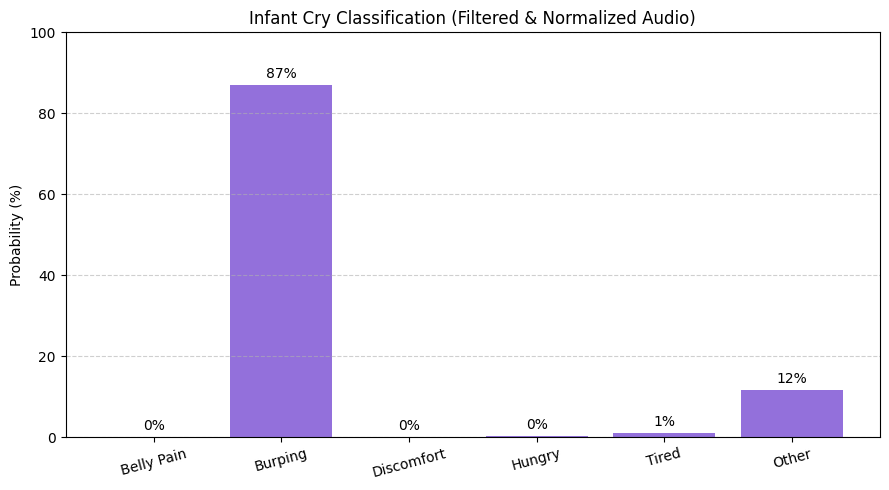

C:\Users\Sajjad Ali\Desktop\fasseh final model\BellyPain.wav

In [27]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import sounddevice as sd
from scipy.io.wavfile import write
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from IPython.display import FileLink, display

# Configuration
DURATION = 10  # seconds
SAMPLE_RATE = 44100  # Original sample rate
TARGET_SAMPLE_RATE = 16000  # Model expects this
FILENAME = "./BellyPain.wav"
my_classes = ['Belly Pain', 'Burping', 'Discomfort', 'Hungry', 'Tired', 'Other']

# GPU memory growth
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Bandpass filter (400Hz - 5000Hz)
def butter_bandpass(lowcut=400.0, highcut=5000.0, fs=44100, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

def apply_bandpass_filter(data, fs):
    b, a = butter_bandpass(fs=fs)
    return lfilter(b, a, data)

# Voice Activity Detection (basic energy-based)
def trim_silence(audio, threshold=0.02):
    energy = np.abs(audio)
    indices = np.where(energy > threshold)[0]
    if indices.size:
        return audio[indices[0]:indices[-1]+1]
    return audio

# Step 1: Record
print(f"\n🎤 Recording {DURATION} seconds of audio...")
audio = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype='int16')
sd.wait()
audio = audio.flatten()

# Step 2: Filter and normalize
filtered = apply_bandpass_filter(audio.astype(np.float32), fs=SAMPLE_RATE)
filtered /= np.max(np.abs(filtered)) + 1e-7  # Avoid division by zero
filtered = trim_silence(filtered)

# Step 3: Save filtered audio
write(FILENAME, SAMPLE_RATE, (filtered * 32767).astype(np.int16))
print(f"✅ Cleaned audio saved as '{FILENAME}'")

# Step 4: Load audio and resample
@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    wav = tfio.audio.resample(wav, rate_in=tf.cast(sample_rate, tf.int64), rate_out=TARGET_SAMPLE_RATE)
    return wav

# Step 5: Load model
saved_model_path = './model'
reloaded_model = tf.saved_model.load(saved_model_path)

# Step 6: Predict
audio_tensor = load_wav_16k_mono(FILENAME)  # shape: (samples,)
logits = reloaded_model(audio_tensor, False, None)  # no batch dimension
logits = tf.squeeze(logits)
probs = tf.nn.softmax(logits).numpy() * 100

# Display results
result = my_classes[np.argmax(probs)]

print(f"\n🔊 Detected cry category: {result}")
print("\n📊 Class Probabilities:")
for cls, prob in zip(my_classes, probs):
    print(f"{cls.ljust(12)} {prob:.0f}%")

# Step 8: Plot
plt.figure(figsize=(9, 5))
bars = plt.bar(my_classes, probs, color='mediumpurple')
for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height() + 1, f'{prob:.0f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.ylabel("Probability (%)")
plt.title("Infant Cry Classification (Filtered & Normalized Audio)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: Provide download link
display(FileLink(FILENAME))


⚠ No GPU found, using CPU.



The main sound is: Discomfort

Probabilities:
Belly Pain   0%
Burping      0%
Discomfort   95%
Hungry       2%
Tired        0%
Other        2%


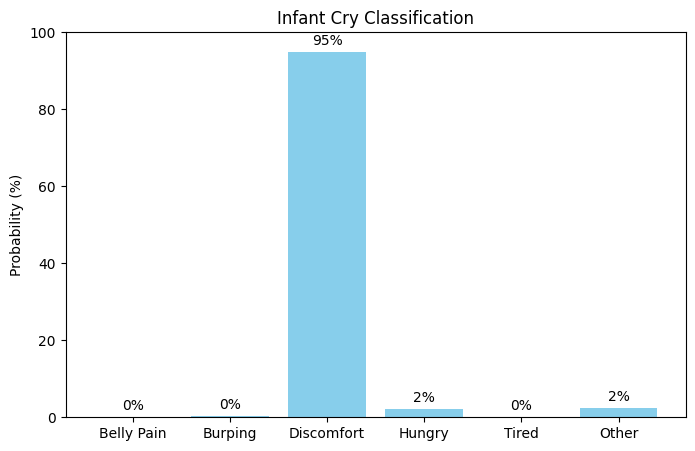

In [29]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("⚠ No GPU found, using CPU.")

FILENAME = r"C:\Users\FUJITSU\Documents\AudiosforTest\test.wav"  # File to read


@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


my_classes = ['Belly Pain', 'Burping', 'Discomfort', 'Hungry', 'Tired', 'Other']

saved_model_path = './model'  # Trained model path

reloaded_model = tf.saved_model.load(saved_model_path)

# Run prediction
logits = reloaded_model(load_wav_16k_mono(FILENAME))  # Output shape: (1, 5) most likely
logits = tf.squeeze(logits)  # Now shape: (5,)
probs = tf.nn.softmax(logits).numpy() * 100  # Now a NumPy array with 5 probabilities

# Get result
result = my_classes[np.argmax(probs)]

# Print main sound
print(f"\nThe main sound is: {result}")

# Print probabilities nicely
print("\nProbabilities:")
for cls, prob in zip(my_classes, probs):
    print(f"{cls.ljust(12)} {prob:.0f}%")

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(my_classes, probs, color='skyblue')

# Add percentage labels
for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height() + 1, f'{prob:.0f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.ylabel("Probability (%)")
plt.title("Infant Cry Classification")
plt.show()